**The autoregressive integrated moving average model.**


An autoregressive integrated moving average (ARIMA) process is the combination of
the AR(p) and MA(q) processes, but in terms of the differenced series.
It is denoted as ARIMA(p,d,q), where p is the order of the AR(p) process, d is the order
of integration, and q is the order of the MA(q) process.
Integration is the reverse of differencing, and the order of integration d is equal to the
number of times the series has been differenced to be rendered stationary.
The general equation of the ARIMA(p,d,q) process is  
$y'_t = C + ϕ_1 y'_{t–1} +⋅⋅⋅ ϕ_p y'_{t–p} + θ_1ϵ'_{t–1} +⋅⋅⋅+ θ_qϵ'_{t–q} + ϵ_t$  
Note that $y'_t$ represents the differenced series, and it may have been differenced
more than once.

The order of integration d is simply the minimum number of times a series must be differenced to become stationary. Therefore, if a series is stationary after being differenced once, then d = 1. If it is stationary after being differenced twice, then d = 2. a time series rarely needs to be differenced more than twice to become stationary.

### Forecasting a non-stationary times series

In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../data/jj.csv')
df.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


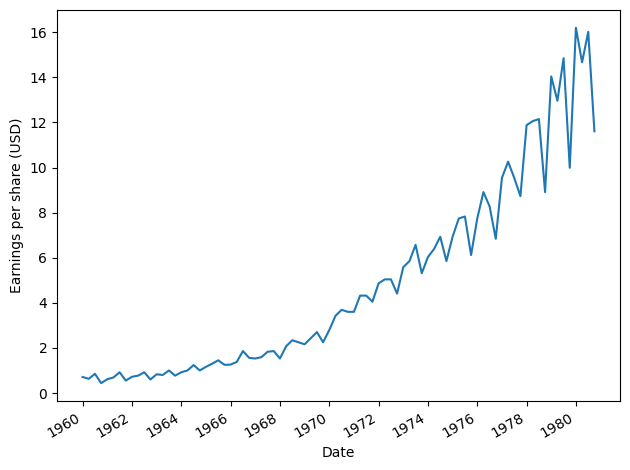

In [3]:
fig, ax = plt.subplots()

ax.plot(df.date, df['data'])
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

In [4]:
ad_fuller_result = adfuller(df['data'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 2.742016573457485
p-value: 1.0


In [5]:
eps_diff = np.diff(df['data'], n=1)

ad_fuller_result = adfuller(eps_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -0.4074097636380523
p-value: 0.9088542416911295


In [6]:

eps_diff2 = np.diff(eps_diff, n=1)

ad_fuller_result = adfuller(eps_diff2)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -3.585162874793164
p-value: 0.0060510998696034985


In [7]:
def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df


In [8]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
d = 2

order_list = list(product(ps, qs))

In [9]:
train = df['data'][:-4]

result_df = optimize_ARIMA(train, order_list, d)
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(3, 3)",115.276127
1,"(3, 1)",115.624980
2,"(3, 2)",115.672007
3,"(3, 0)",154.430621
4,"(0, 3)",194.654716
5,"(0, 2)",209.274518
6,"(2, 3)",220.666852
7,"(1, 3)",228.267829
8,"(1, 2)",228.935869
9,"(2, 2)",229.974678


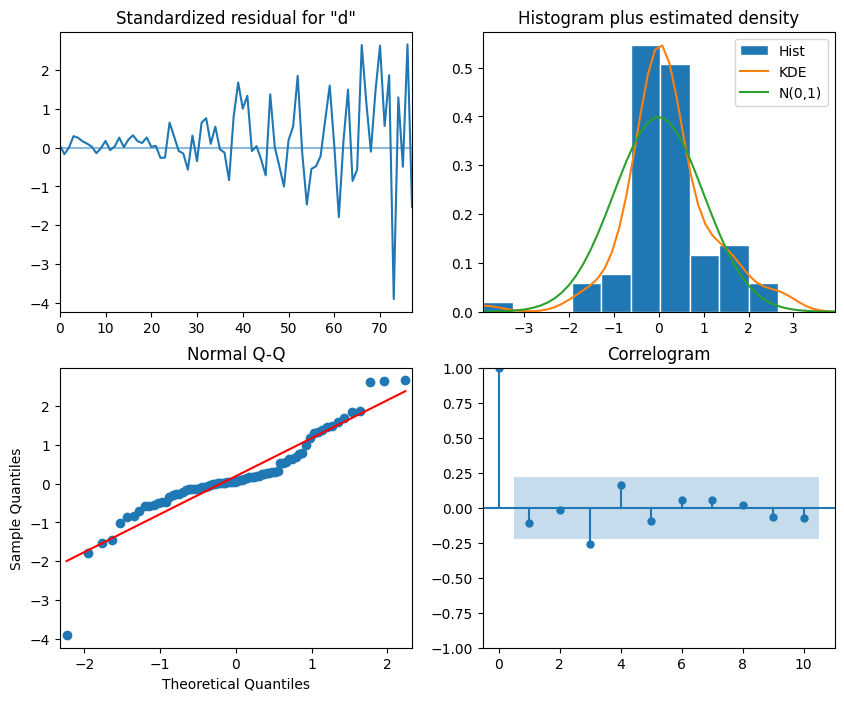

In [10]:
model = SARIMAX(train, order=(3,2,3), simple_differencing=False)
model_fit = model.fit(disp=False)
model_fit.plot_diagnostics(figsize=(10,8));

In [14]:

residuals = model_fit.resid
value = acorr_ljungbox(residuals, np.arange(1, 11, 1))
value.iloc[:,1]

1     0.218249
2     0.467291
3     0.066778
4     0.060463
5     0.086218
6     0.130111
7     0.181294
8     0.253651
9     0.310454
10    0.360244
Name: lb_pvalue, dtype: float64

In [15]:
test = df.iloc[-4:]

test['naive_seasonal'] = df['data'].iloc[76:80].values
test

,date,data,naive_seasonal
80,1980-01-01,16.20,14.04
81,1980-04-01,14.67,12.96
82,1980-07-02,16.02,14.85
83,1980-10-01,11.61,9.99


In [16]:
ARIMA_pred = model_fit.get_prediction(80, 83).predicted_mean

test['ARIMA_pred'] = ARIMA_pred
test

,date,data,naive_seasonal,ARIMA_pred
80,1980-01-01,16.20,14.04,15.851192
81,1980-04-01,14.67,12.96,14.386171
82,1980-07-02,16.02,14.85,16.375475
83,1980-10-01,11.61,9.99,11.679947


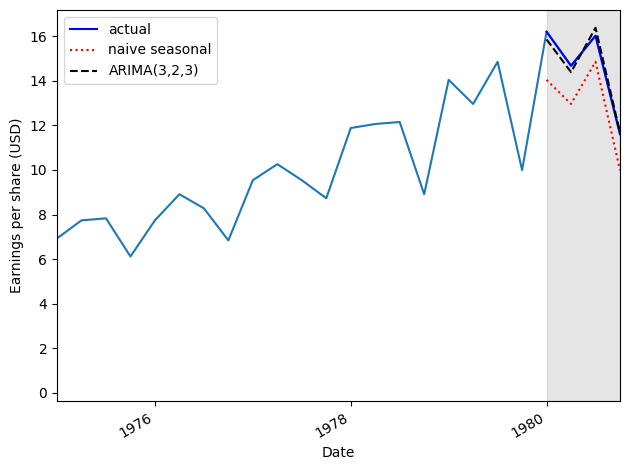

In [17]:
fig, ax = plt.subplots()

ax.plot(df['date'], df['data'])
ax.plot(test['data'], 'b-', label='actual')
ax.plot(test['naive_seasonal'], 'r:', label='naive seasonal')
ax.plot(test['ARIMA_pred'], 'k--', label='ARIMA(3,2,3)')

ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(80, 83, color='#808080', alpha=0.2)

ax.legend(loc=2)

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])
ax.set_xlim(60, 83)

fig.autofmt_xdate()
plt.tight_layout()

In [18]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [19]:
mape_naive_seasonal = mape(test['data'], test['naive_seasonal'])
mape_ARIMA = mape(test['data'], test['ARIMA_pred'])

print(mape_naive_seasonal, mape_ARIMA)

11.561658552433654 1.7273280245593163


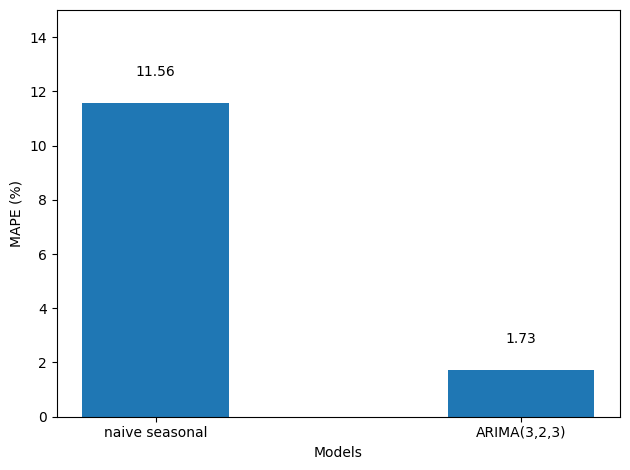

In [20]:
fig, ax = plt.subplots()

x = ['naive seasonal', 'ARIMA(3,2,3)']
y = [mape_naive_seasonal, mape_ARIMA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 15)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')

plt.tight_layout()